<h1 align="center">홍수기간 댐 유입량 예측 - LSTM </h1>

1. [Preparation](#1) <a id=11></a>
    - 1.1 [Packages](#2)
    - 1.2 [Data](#3)
    - 1.3 [Understanding Data](#4)
2. [Masking](#5)
3. [Data Preprocessing](#6)
    - 3.1 [Packages for Modeling](#7)
    - 3.2 [Making features model ready](#8)
    - 3.3 [Train/Test Split](#9)
4. [Modeling](#10)

### 1. Preparation <a id=1></a>
[back to top](#11)

#### 1.1 Packages <a id=2></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt

#### 1.2 Data <a id=3></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename = '/content/drive/MyDrive/01_제공데이터/data.xlsx'

# double column의 문제 해결을 위해 raw data 형식 변경
data = pd.read_excel(filename, header = 1)

# 코딩 시 편하도록 변수명 영어로 변경
data.columns = ['event', 'year', 'month', 'day', 'time', 'target', 
                 'avg_rain1', 'rainA_g1', 'rainB_g1', 'rainC_g1', 'rainD_g1', 'levelE_g1','levelD_g1',
                 'avg_rain2', 'rainA_g2', 'rainB_g2', 'rainC_g2', 'rainD_g2', 'levelE_g2','levelD_g2',
                 'avg_rain3', 'rainA_g3', 'rainB_g3', 'rainC_g3', 'rainD_g3', 'levelE_g3','levelD_g3',
                 'avg_rain4', 'rainA_g4', 'rainB_g4', 'rainC_g4', 'rainD_g4', 'levelE_g4','levelD_g4',
                 'avg_rain5', 'rainA_g5', 'rainB_g5', 'rainC_g5', 'rainD_g5', 'levelE_g5','levelD_g5',
                 'avg_rain6', 'rainA_g6', 'rainB_g6', 'rainC_g6', 'rainD_g6', 'levelE_g6','levelD_g6'
                ]

#### 1.3 Understanding Data  <a id=4></a>

##### 1.3.1 The shape of the data

In [4]:
print("The shape of the raw dataset is", data.shape)

The shape of the raw dataset is (3051, 48)


##### 1.3.2 Preview of the first 5 rows of the data

In [5]:
data.head()

,event,year,month,day,time,target,avg_rain1,rainA_g1,rainB_g1,rainC_g1,rainD_g1,levelE_g1,levelD_g1,avg_rain2,rainA_g2,rainB_g2,rainC_g2,rainD_g2,levelE_g2,levelD_g2,avg_rain3,rainA_g3,rainB_g3,rainC_g3,rainD_g3,levelE_g3,levelD_g3,avg_rain4,rainA_g4,rainB_g4,rainC_g4,rainD_g4,levelE_g4,levelD_g4,avg_rain5,rainA_g5,rainB_g5,rainC_g5,rainD_g5,levelE_g5,levelD_g5,avg_rain6,rainA_g6,rainB_g6,rainC_g6,rainD_g6,levelE_g6,levelD_g6
0,1,2006,7,10,8,189.100000,6.4,7,7,7,8,2.54,122.56875,6.3,7,7,7,8,2.54,122.541667,6.3,7,7,7,8,2.54,122.550000,6.4,7,7,8,8,2.54,122.675000,6.4,7,7,8,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,8,2.53,122.56250,6.4,7,8,7,8,2.53,122.550000,6.4,7,8,7,8,2.53,122.558333,7.3,7,8,10,10,2.53,122.667857,7.3,7,8,10,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,8,2.53,122.55625,7.3,7,9,7,8,2.53,122.558333,7.3,7,9,8,8,2.53,122.566667,8.2,7,9,10,11,2.53,122.660714,8.2,7,9,10,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,8,2.53,122.55625,8.2,7,10,8,8,2.53,122.566667,8.2,7,10,10,10,2.53,122.575000,11.3,9,10,15,14,2.53,122.653571,11.3,9,10,15,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,10,2.53,122.55625,11.3,9,12,10,10,2.53,122.575000,11.3,9,12,10,11,2.53,122.575000,14.4,12,12,18,16,2.53,122.639286,14.4,12,12,18,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [6]:
data.dtypes

event          int64
year           int64
month          int64
day            int64
time           int64
target       float64
avg_rain1    float64
rainA_g1       int64
rainB_g1       int64
rainC_g1       int64
rainD_g1       int64
levelE_g1    float64
levelD_g1    float64
avg_rain2    float64
rainA_g2       int64
rainB_g2       int64
rainC_g2       int64
rainD_g2       int64
levelE_g2    float64
levelD_g2    float64
avg_rain3    float64
rainA_g3       int64
rainB_g3       int64
rainC_g3       int64
rainD_g3       int64
levelE_g3    float64
levelD_g3    float64
avg_rain4    float64
rainA_g4       int64
rainB_g4       int64
rainC_g4       int64
rainD_g4       int64
levelE_g4    float64
levelD_g4    float64
avg_rain5    float64
rainA_g5       int64
rainB_g5       int64
rainC_g5       int64
rainD_g5       int64
levelE_g5    float64
levelD_g5    float64
avg_rain6    float64
rainA_g6       int64
rainB_g6       int64
rainC_g6       int64
rainD_g6       int64
levelE_g6    float64
levelD_g6    

In [7]:
data.loc[(data.time == 24), ].head()

,event,year,month,day,time,target,avg_rain1,rainA_g1,rainB_g1,rainC_g1,rainD_g1,levelE_g1,levelD_g1,avg_rain2,rainA_g2,rainB_g2,rainC_g2,rainD_g2,levelE_g2,levelD_g2,avg_rain3,rainA_g3,rainB_g3,rainC_g3,rainD_g3,levelE_g3,levelD_g3,avg_rain4,rainA_g4,rainB_g4,rainC_g4,rainD_g4,levelE_g4,levelD_g4,avg_rain5,rainA_g5,rainB_g5,rainC_g5,rainD_g5,levelE_g5,levelD_g5,avg_rain6,rainA_g6,rainB_g6,rainC_g6,rainD_g6,levelE_g6,levelD_g6
16,1,2006,7,10,24,1299.827525,55.9,39,60,45,56,3.80,122.52500,57.0,41,60,46,56,3.80,122.500000,57.0,41,58,48,58,3.80,122.525000,58.2,43,58,53,60,3.80,122.542857,58.2,43,58,53,60,3.80,122.548,57.9,43,59,50,60,3.80,122.540
40,1,2006,7,11,24,1244.857022,59.4,42,60,51,61,4.94,124.06250,59.7,42,60,51,61,4.94,124.216667,59.7,42,60,50,61,4.94,124.308333,59.2,42,60,51,61,4.94,123.660714,58.4,42,60,51,61,4.94,123.784,58.4,42,60,43,61,4.94,123.900
64,1,2006,7,12,24,2200.770442,102.1,152,80,19,20,6.30,125.76875,102.2,158,73,18,20,6.30,125.841667,102.2,158,53,18,26,6.30,125.866667,103.9,163,53,29,44,6.30,125.460714,92.7,163,53,29,44,6.30,125.564,68.5,163,54,19,44,6.30,125.665
88,1,2006,7,13,24,3492.298810,109.4,241,88,31,73,8.19,128.64375,109.5,241,88,28,73,8.19,129.091667,109.5,241,87,25,73,8.19,129.325000,109.8,241,87,35,72,8.19,127.750000,109.8,241,87,35,72,8.19,127.972,109.5,241,88,18,72,8.19,128.220
112,1,2006,7,14,24,1689.172367,96.4,197,66,15,37,5.17,132.25625,93.6,197,63,13,37,5.17,132.375000,93.6,197,56,13,45,5.17,132.400000,92.0,197,56,17,45,5.17,131.725000,88.2,197,56,17,45,5.17,131.908,73.2,197,59,10,42,5.17,132.090


In [8]:
# datetime형식으로 변환하기 위하여 24시를 0시로 대체
data.loc[(data.time == 24), 'time'] = 0

# 0시로 대체한 데이터 day컬럼 + 1
data.loc[(data.time == 0), 'day'] += 1

data.loc[data.time == 0, ].head()

,event,year,month,day,time,target,avg_rain1,rainA_g1,rainB_g1,rainC_g1,rainD_g1,levelE_g1,levelD_g1,avg_rain2,rainA_g2,rainB_g2,rainC_g2,rainD_g2,levelE_g2,levelD_g2,avg_rain3,rainA_g3,rainB_g3,rainC_g3,rainD_g3,levelE_g3,levelD_g3,avg_rain4,rainA_g4,rainB_g4,rainC_g4,rainD_g4,levelE_g4,levelD_g4,avg_rain5,rainA_g5,rainB_g5,rainC_g5,rainD_g5,levelE_g5,levelD_g5,avg_rain6,rainA_g6,rainB_g6,rainC_g6,rainD_g6,levelE_g6,levelD_g6
16,1,2006,7,11,0,1299.827525,55.9,39,60,45,56,3.80,122.52500,57.0,41,60,46,56,3.80,122.500000,57.0,41,58,48,58,3.80,122.525000,58.2,43,58,53,60,3.80,122.542857,58.2,43,58,53,60,3.80,122.548,57.9,43,59,50,60,3.80,122.540
40,1,2006,7,12,0,1244.857022,59.4,42,60,51,61,4.94,124.06250,59.7,42,60,51,61,4.94,124.216667,59.7,42,60,50,61,4.94,124.308333,59.2,42,60,51,61,4.94,123.660714,58.4,42,60,51,61,4.94,123.784,58.4,42,60,43,61,4.94,123.900
64,1,2006,7,13,0,2200.770442,102.1,152,80,19,20,6.30,125.76875,102.2,158,73,18,20,6.30,125.841667,102.2,158,53,18,26,6.30,125.866667,103.9,163,53,29,44,6.30,125.460714,92.7,163,53,29,44,6.30,125.564,68.5,163,54,19,44,6.30,125.665
88,1,2006,7,14,0,3492.298810,109.4,241,88,31,73,8.19,128.64375,109.5,241,88,28,73,8.19,129.091667,109.5,241,87,25,73,8.19,129.325000,109.8,241,87,35,72,8.19,127.750000,109.8,241,87,35,72,8.19,127.972,109.5,241,88,18,72,8.19,128.220
112,1,2006,7,15,0,1689.172367,96.4,197,66,15,37,5.17,132.25625,93.6,197,63,13,37,5.17,132.375000,93.6,197,56,13,45,5.17,132.400000,92.0,197,56,17,45,5.17,131.725000,88.2,197,56,17,45,5.17,131.908,73.2,197,59,10,42,5.17,132.090


In [9]:
# day가 31인 data 확인
data.loc[data['day']==31, ].groupby(data['month']).size()

month
6     1
7    24
8    24
dtype: int64

In [10]:
# day가 32인 data 확인
data.loc[data.day == 32, ['month', 'day']]

,month,day
1582,7,32
2244,8,32


In [11]:
# 30일까지 있는 month에 31일이 들어가 있다면 month +1, day = 1
# 32일 data :  month +1, day = 1
data.loc[(data['month'] == 6) & (data['day'] == 31), 'month'] = 7
data.loc[(data['month'] == 6) & (data['day'] == 31), 'day'] = 1
data.loc[data.day == 32,'month'] += 1
data.loc[data.day == 32, 'day'] = 1

In [12]:
# date 컬럼 생성
date = []
for i in range(0,data.shape[0]):
    pd_ts = pd.Timestamp(data['year'][i], data['month'][i],data['day'][i],data['time'][i],0,0)
    #time.append(pd_ts.time())
    date.append(pd.Timestamp.combine(pd_ts.date(), pd_ts.time()))

data['date'] = pd.DataFrame(date)

In [13]:
# train set 생성
datalist = data[data['event'] <= 25] 

### 2. Masking <a id=5></a>
[back to top](#11)

In [14]:
def dates(years, start, end):
    dates = []
    for year in years:
        start_year = year + start
        end_year = year + end
        start_date = pd.to_datetime(start_year)
        end_date = pd.to_datetime(end_year)
        date = pd.date_range(start_date, end_date, freq = 'H')
        dates.append(date)
    Date = pd.melt(pd.DataFrame(dates).transpose())
    Date = Date.drop('variable', axis = 1)
    Date.columns = ['date']
    return Date

In [15]:
years = ['2006','2007','2008','2009','2010','2011','2012','2013','2017']
start = '0628'
end = '0925'
Date = dates(years, start, end)
Date

,date
0,2006-06-28 00:00:00
1,2006-06-28 01:00:00
2,2006-06-28 02:00:00
3,2006-06-28 03:00:00
4,2006-06-28 04:00:00
...,...
19228,2017-09-24 20:00:00
19229,2017-09-24 21:00:00
19230,2017-09-24 22:00:00
19231,2017-09-24 23:00:00


In [16]:
# 데이터셋 생성
df = pd.merge(Date,datalist , on = 'date', how = 'left')

# na값 0으로 대체
df.fillna(0, inplace = True)
# 'date' index 지정
df.set_index('date', inplace = True)
df.head()

,event,year,month,day,time,target,avg_rain1,rainA_g1,rainB_g1,rainC_g1,rainD_g1,levelE_g1,levelD_g1,avg_rain2,rainA_g2,rainB_g2,rainC_g2,rainD_g2,levelE_g2,levelD_g2,avg_rain3,rainA_g3,rainB_g3,rainC_g3,rainD_g3,levelE_g3,levelD_g3,avg_rain4,rainA_g4,rainB_g4,rainC_g4,rainD_g4,levelE_g4,levelD_g4,avg_rain5,rainA_g5,rainB_g5,rainC_g5,rainD_g5,levelE_g5,levelD_g5,avg_rain6,rainA_g6,rainB_g6,rainC_g6,rainD_g6,levelE_g6,levelD_g6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-06-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-06-28 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-06-28 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-06-28 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-06-28 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Data Preprocessing <a id=6></a>
[back to top](#11)

#### 3.1 Packages for Modeling <a id=7></a>

In [17]:
# 전처리
from sklearn.preprocessing import MinMaxScaler

# Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

# 평가 지표
from sklearn.metrics import mean_squared_error

#### 3.2 Making features model ready <a id=8></a>

##### 3.2.1 Scaling features

In [18]:
cols = list(df)[5:]
print('Training set shape == {}'.format(df.shape))
print('Featured selected: {}'.format(cols))

Training set shape == (19234, 48)
Featured selected: ['target', 'avg_rain1', 'rainA_g1', 'rainB_g1', 'rainC_g1', 'rainD_g1', 'levelE_g1', 'levelD_g1', 'avg_rain2', 'rainA_g2', 'rainB_g2', 'rainC_g2', 'rainD_g2', 'levelE_g2', 'levelD_g2', 'avg_rain3', 'rainA_g3', 'rainB_g3', 'rainC_g3', 'rainD_g3', 'levelE_g3', 'levelD_g3', 'avg_rain4', 'rainA_g4', 'rainB_g4', 'rainC_g4', 'rainD_g4', 'levelE_g4', 'levelD_g4', 'avg_rain5', 'rainA_g5', 'rainB_g5', 'rainC_g5', 'rainD_g5', 'levelE_g5', 'levelD_g5', 'avg_rain6', 'rainA_g6', 'rainB_g6', 'rainC_g6', 'rainD_g6', 'levelE_g6', 'levelD_g6']


In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # data가 list면 n_var = 1, list 아니면 n_var = data.shape[1]
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    # input : (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) # 행 상단에서 하단으로 이동
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast : (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)) # 행 하단에서 상단으로 이동
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # columns concat
    agg = concat(cols, axis=1)
    agg.columns = names
    # nan 값 drop
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [20]:
# load dataset
dataset= df[cols].astype(float)
training_set = dataset.to_numpy()
print('Shape of training set == {}'.format(training_set.shape))

Shape of training set == (19234, 43)


In [21]:
# MinMaxScaler를 사용하여 0~1 사이의 범위로 scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(training_set)

#frame as supervised learning(지도학습)
reframed = series_to_supervised(scaled, 1,1)
reframed.drop(reframed.columns[44:], axis = 1, inplace = True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var27(t-1),var28(t-1),var29(t-1),var30(t-1),var31(t-1),var32(t-1),var33(t-1),var34(t-1),var35(t-1),var36(t-1),var37(t-1),var38(t-1),var39(t-1),var40(t-1),var41(t-1),var42(t-1),var43(t-1),var1(t)
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
reframed.shape

(19233, 44)

#### 3.3 Train/Test Split <a id=9></a>

In [23]:
# train, test set 
values = reframed.values
n_train_hours = int(len(dataset)*0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# input, output 나누기
trainX, trainY = train[:, :-1], train[:,-1]
testX, testY = test[:,:-1], test[:,-1]

In [24]:
# input 3차원으로 reshape [samples, timesteps,features] 
trainX = trainX.reshape((trainX.shape[0],1,trainX.shape[1]))
testX = testX.reshape((testX.shape[0],1,testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(15387, 1, 43) (15387,) (3846, 1, 43) (3846,)


## 4. Modeling <a id=10></a>
[back to top](#11)

In [25]:
model = Sequential()
model.add(LSTM(50, input_shape = (trainX.shape[1],trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [26]:
history = model.fit(trainX, trainY, epochs = 30, batch_size = 72, validation_data = (testX,testY))

Epoch 1/30
214/214 [==============================] - 3s 5ms/step - loss: 2.8733e-04 - val_loss: 7.2732e-05
Epoch 2/30
214/214 [==============================] - 1s 3ms/step - loss: 1.1384e-04 - val_loss: 5.4642e-05
Epoch 3/30
214/214 [==============================] - 1s 3ms/step - loss: 1.0745e-04 - val_loss: 4.6072e-05
Epoch 4/30
214/214 [==============================] - 1s 3ms/step - loss: 6.4192e-05 - val_loss: 3.2666e-05
Epoch 5/30
214/214 [==============================] - 1s 3ms/step - loss: 7.1131e-05 - val_loss: 5.1581e-05
Epoch 6/30
214/214 [==============================] - 1s 3ms/step - loss: 5.2992e-05 - val_loss: 2.3893e-05
Epoch 7/30
214/214 [==============================] - 1s 3ms/step - loss: 4.8083e-05 - val_loss: 2.1596e-05
Epoch 8/30
214/214 [==============================] - 1s 3ms/step - loss: 4.8723e-05 - val_loss: 1.1090e-04
Epoch 9/30
214/214 [==============================] - 1s 3ms/step - loss: 5.2223e-05 - val_loss: 3.3759e-05
Epoch 10/30
214/214 [=======

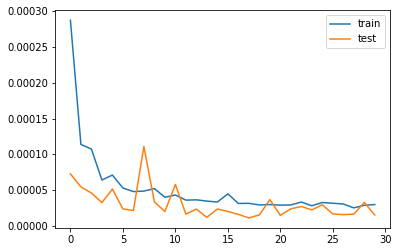

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [28]:
yhat = model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, testX[:,1:]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
testY = testY.reshape((len(testY),1))
inv_y = np.concatenate((testY,testX[:,1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE : %.3f' %rmse)

Test RMSE : 84.321
